# Проект: классификация

In [120]:
import pandas as pd
import numpy as np

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем специальный инструмент для машинного обучения
from  sklearn.ensemble import IsolationForest
import warnings
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

# Импорт для работы с кодировщиком
import category_encoders as ce 

# Импортируем инструмент для подбора оптимальных параметров для модели
from sklearn.model_selection import GridSearchCV

# Импортируем инструмент для классификации градиентный бустинг
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

import optuna

warnings.filterwarnings('ignore')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

### Данные, связанные с последним контактом:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

### Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:
* deposit.

In [2]:
# Загружаем данные
df = pd.read_csv('data/bank_fin.csv', sep = ';')

# Знакомимся с данными
display(df.head(4))

# Знакомимся с данными
display(df.info())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

### Задание 1

Исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

In [3]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В данных есть 25 пропусков в столбце balance.

### Задание 2

Есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

In [5]:
# Находим уникальные знвчения в признаке job
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Скрытые пропуски в признаке job обозначены словом unknown, их 70 штук.

### Задание 3

Преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float).

In [6]:
# Функия делает объект в столбце balance вещественным числом
def convert_balance_float(data):
    data=str(data)
    data=data.replace(',', '.')
    data=data.replace('$', '')
    data=data.replace(' ', '')  
    data = float(data)
    return data


# Реализуем функцию convert_balance_float
df['balance'] = df['balance'].apply(convert_balance_float)

# Вычислили среднее значение по преобразованному в корректный вид признаку balance
print(f"Средний баланс: {round(df['balance'].mean(), 3)}.")

Средний баланс: 1529.129.


### Задание 4

Обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку.

In [7]:
# Пропуски в признаки balance заменили на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

# Вычислили среднее значение по balance
print(f"Средний баланс после замены пропусков медианным значением: {round(df['balance'].mean(), 3)}.")

Средний баланс после замены пропусков медианным значением: 1526.936.


### Задание 5

Обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения.

Пропуски обозначены словом unknown.

In [8]:
# Находим модальные значения job и education
moda_job = df['job'].mode()
moda_education = df['education'].mode()
print(f"Самая популярная работа: {moda_job[0]}")
print(f"Самый популярный уровень образования: {moda_education[0]}.")

# Заменяем пропуски в job и education модальным значением
df['job'] = df['job'].apply(lambda x: moda_job[0] if 'unknown' in x else x) 
df['education'] = df['education'].apply(lambda x: moda_education[0] if 'unknown' in x else x) 

Самая популярная работа: management
Самый популярный уровень образования: secondary.


In [9]:
# Расчитываем средний баланс для клиентов по уровню обрзования и работе
df.groupby(['education', 'job'])['balance'].mean()

education  job          
primary    admin.            775.928571
           blue-collar      1304.818444
           entrepreneur     1314.707317
           housemaid        1366.444444
           management       1841.534247
           retired          2222.631769
           self-employed    1254.928571
           services         1383.554217
           student          1492.047619
           technician       1805.975610
           unemployed       1607.392857
secondary  admin.           1189.494662
           blue-collar      1125.866889
           entrepreneur     1304.445161
           housemaid        1018.229885
           management       1598.882979
           retired          2594.966759
           self-employed    1373.517007
           services         1028.724269
           student          1333.574219
           technician       1461.055511
           unemployed       1147.082949
tertiary   admin.           1343.482143
           blue-collar      1730.062500
           entr

Самый популярный уровень образования secondary, самая популярная профессия management. Средний баланс у данного образования и профессии равен 1598.883.

### Задание 6

Удалите все выбросы для признака balance.

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241.0
Верхняя граница: 4063.0


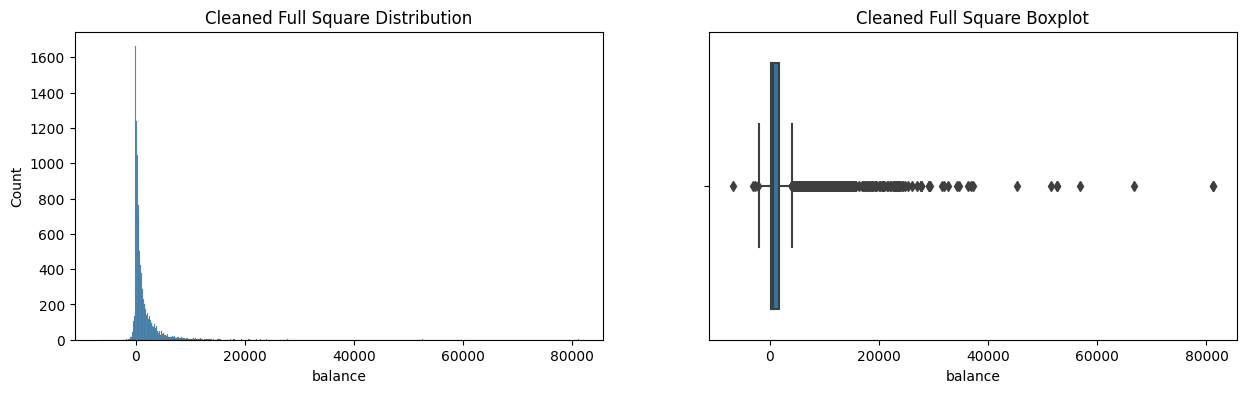

In [10]:
# Функция определяющая выбросы
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

# Применим функцию на признаке balance
outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

# Визуализируем
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [11]:
# Удаляем выбросы
df = df[df['balance']>=-2241.0]
df = df[df['balance']<=4063.0]

## Часть 2:  Разведывательный анализ

### Задание 1

Изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат. Сколько клиентов открыли депозит?

no     5424
yes    4681
Name: deposit, dtype: int64

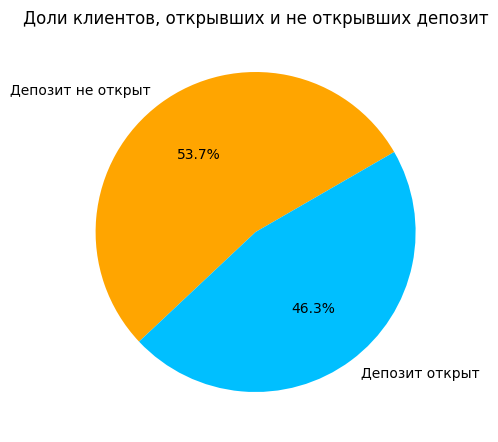

In [16]:
# Сколько клиентов открыли депозит
display(df['deposit'].value_counts())

# Визуализируем, построим круговую диаграмму
fig = plt.figure(figsize=(4, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Доли клиентов, открывших и не открывших депозит')
axes.pie(
    x = df['deposit'].value_counts(normalize=True),
    labels = ['Депозит не открыт', 'Депозит открыт'],
    autopct = '%.1f%%',
    colors = ['orange', 'deepskyblue'],
    startangle = 30
);

Классы не сбалансированы, но разниц между ними не очень большая. Так открыло депозит 4681 человека, что равно 46.3 % всех клиентов.

### Задания 2 и 3

Рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат.

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Самый распространенный возраст клиента банка: 31
Самая распространенная продолжительность разговора с клиентом банка: 161


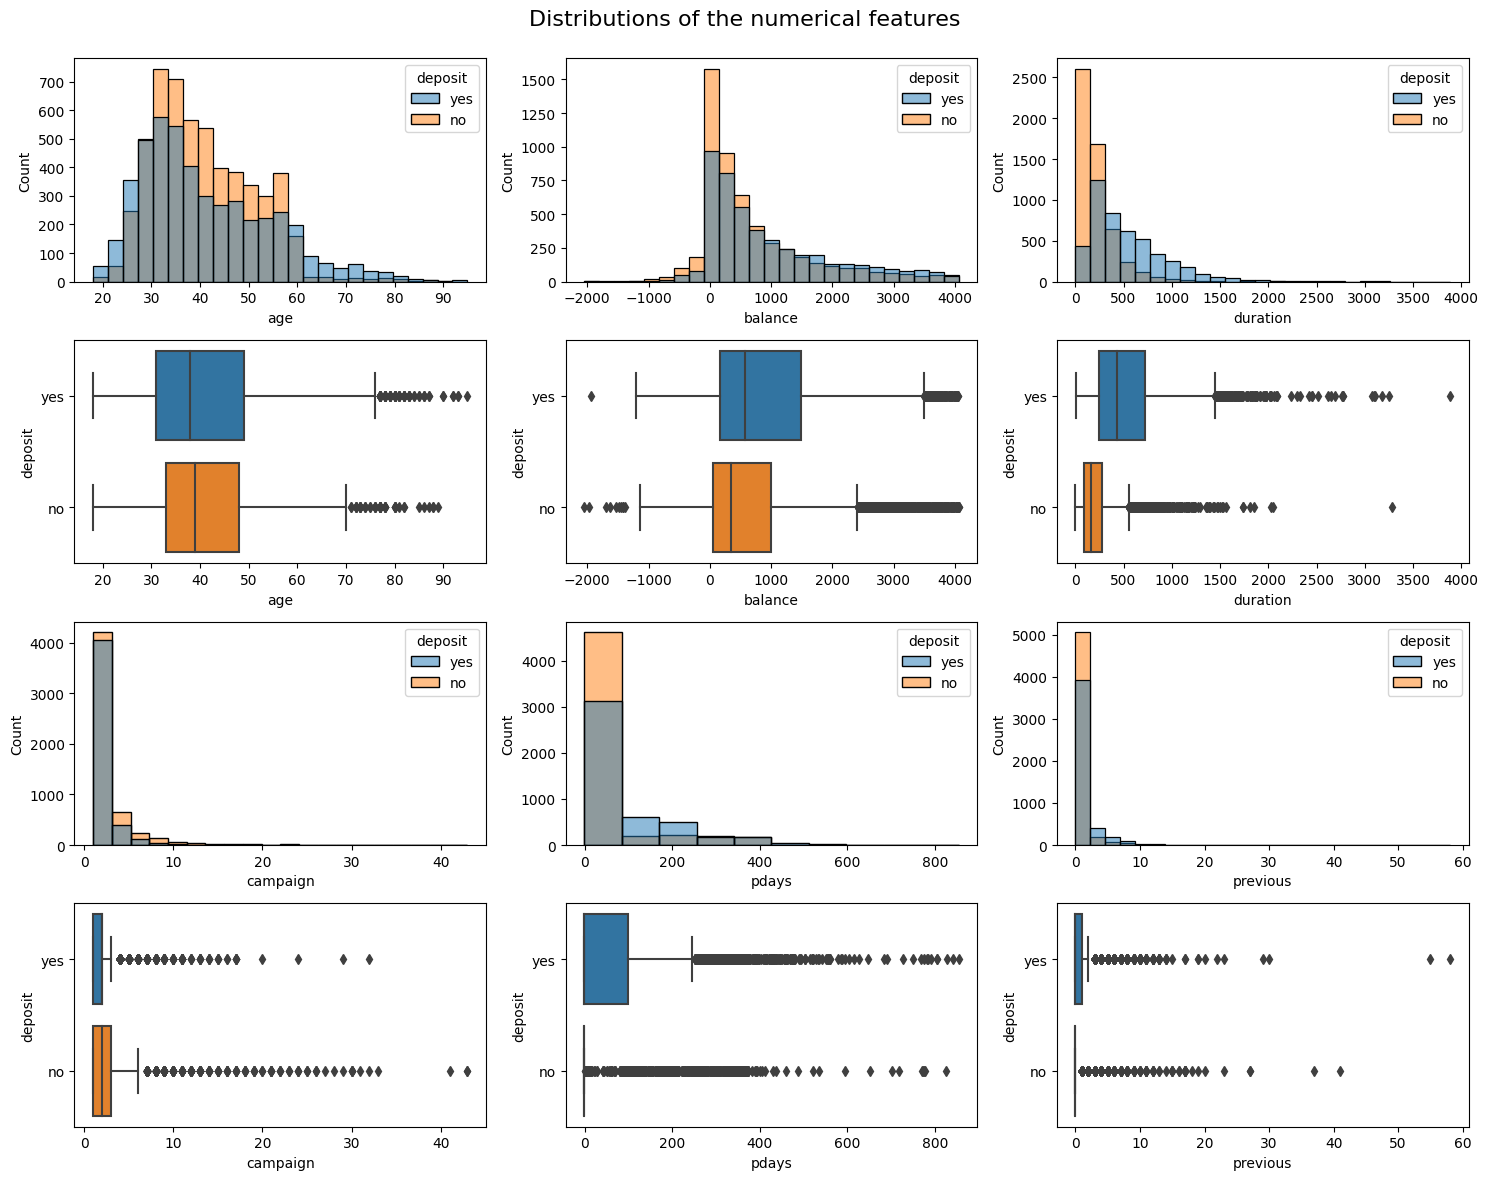

In [23]:
# Основная описательная статистика
display(df.describe())


# Самый распространенный возраст клиента банка
age_mode = df['age'].mode()
print(f'Самый распространенный возраст клиента банка: {age_mode[0]}')


# Самая распространенная продолжительность разговора с клиентом банка
duration_mode = df['duration'].mode()
print(f'Самая распространенная продолжительность разговора с клиентом банка: {duration_mode[0]}')


# Визуализация
fig, ax = plt.subplots(4,3, figsize=(15,12))
sns.histplot(data=df, x='age', hue = 'deposit', bins=25, ax=ax[0,0])       # возраст
sns.histplot(data=df, x='balance', hue = 'deposit', bins=25, ax=ax[0,1])   # баланс
sns.histplot(data=df, x='duration', hue = 'deposit', bins=25, ax=ax[0,2])  # продолжительность контакта
sns.boxplot(data=df, x='age', y='deposit', ax=ax[1,0]) 
sns.boxplot(data=df, x='balance', y='deposit', ax=ax[1,1])
sns.boxplot(data=df, x='duration', y='deposit', ax=ax[1,2])
sns.histplot(data=df, x='campaign', hue = 'deposit', bins=20, ax=ax[2,0])  # количество контактов
sns.histplot(data=df, x='pdays', hue = 'deposit', bins=10, ax=ax[2,1])     # количество дней после предыдущей кампании
sns.histplot(data=df, x='previous', hue = 'deposit', bins=25, ax=ax[2,2])  # количество предыдущих контактов
sns.boxplot(data=df, x='campaign', y='deposit', ax=ax[3,0])
sns.boxplot(data=df, x='pdays', y='deposit', ax=ax[3,1])
sns.boxplot(data=df, x='previous', y='deposit', ax=ax[3,2])
plt.suptitle('Distributions of the numerical features\n', fontsize=16)
plt.tight_layout()

Проинтерпретируем результаты:
* Возраст (age). Возраст клиентов от 18 до 95 лет. Больше всего людей в возрасте от 30 до 45 лет, количество клиентов старше 60 лет резко падает.
* Баланс (balance). Варьируется от -2049 до 4063. Есть небольшое количество отрицательных балансов. Возможно, стоит убрать выбросы отрицательного баланса, расположенные левее границы распределения (менее -1000), так как их количество небольшое, но их наличие сильно влияет на среднее значение. В остальном распределение логнормальное с преобладанием небольших балансов.
* Продолжительность контакта (duration). Варьируется от 2 до 4063. секунд. Средняя продолжительность контакта около 300 секунд(5 минут).
* Количество контактов (campaign). Варьируется от 1 до 43. С большей частью клиентов контактировали 2 - 3 раза.
* Количество дней с момента предыдущей кампании (pdays). Варьируется от -1 до 854. Будем считать, что отрицательное значение, вероятно указывает на то, что с клиентом впервые контактировали в текущей кампании, а отрезок в 854 дня, скорее всего, является аномалией, так как вряд ли кампании проводятся настолько редко.
* Количество предыдущих контактов (previous). Варьируется от 0 до 58. В основном равно 1. Медианное значение равно 0, значит до текущий кампании с клиентами не контактировали, что подтверждает значение -1 у признака pdays. 58 контактов с одним клиентом выглядит аномально.
* День последнего контакта с клиентом (day). Видно, что большинство контактов осуществлены сотрудниками банка в середине месяца между 8 и 22 числами.

Влияние на целевой признак
*  Большая часть клиентов от 30 до 55 с вероятностью больше 50% откажутся от депозитов, но при этом составляют большую часть согласившихся на депозит из-за того, что таких клиентов больше. На вероятное открытие депозита указывает продолжительность контакта - чем он дольше, тем выше шансы положительного результата. Но большее количество контактов говорит о меньших шансах, результат достигается при первых контактах, либо не достигается вообще. Более вероятно открытие депозита у клиентов с большей суммой на счете. Распределение признаков pdays и previous говорит о том, что большинство клиентов, не открывших депозит, относятся к новым.

### Задания 4 и 5

Рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат. Постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


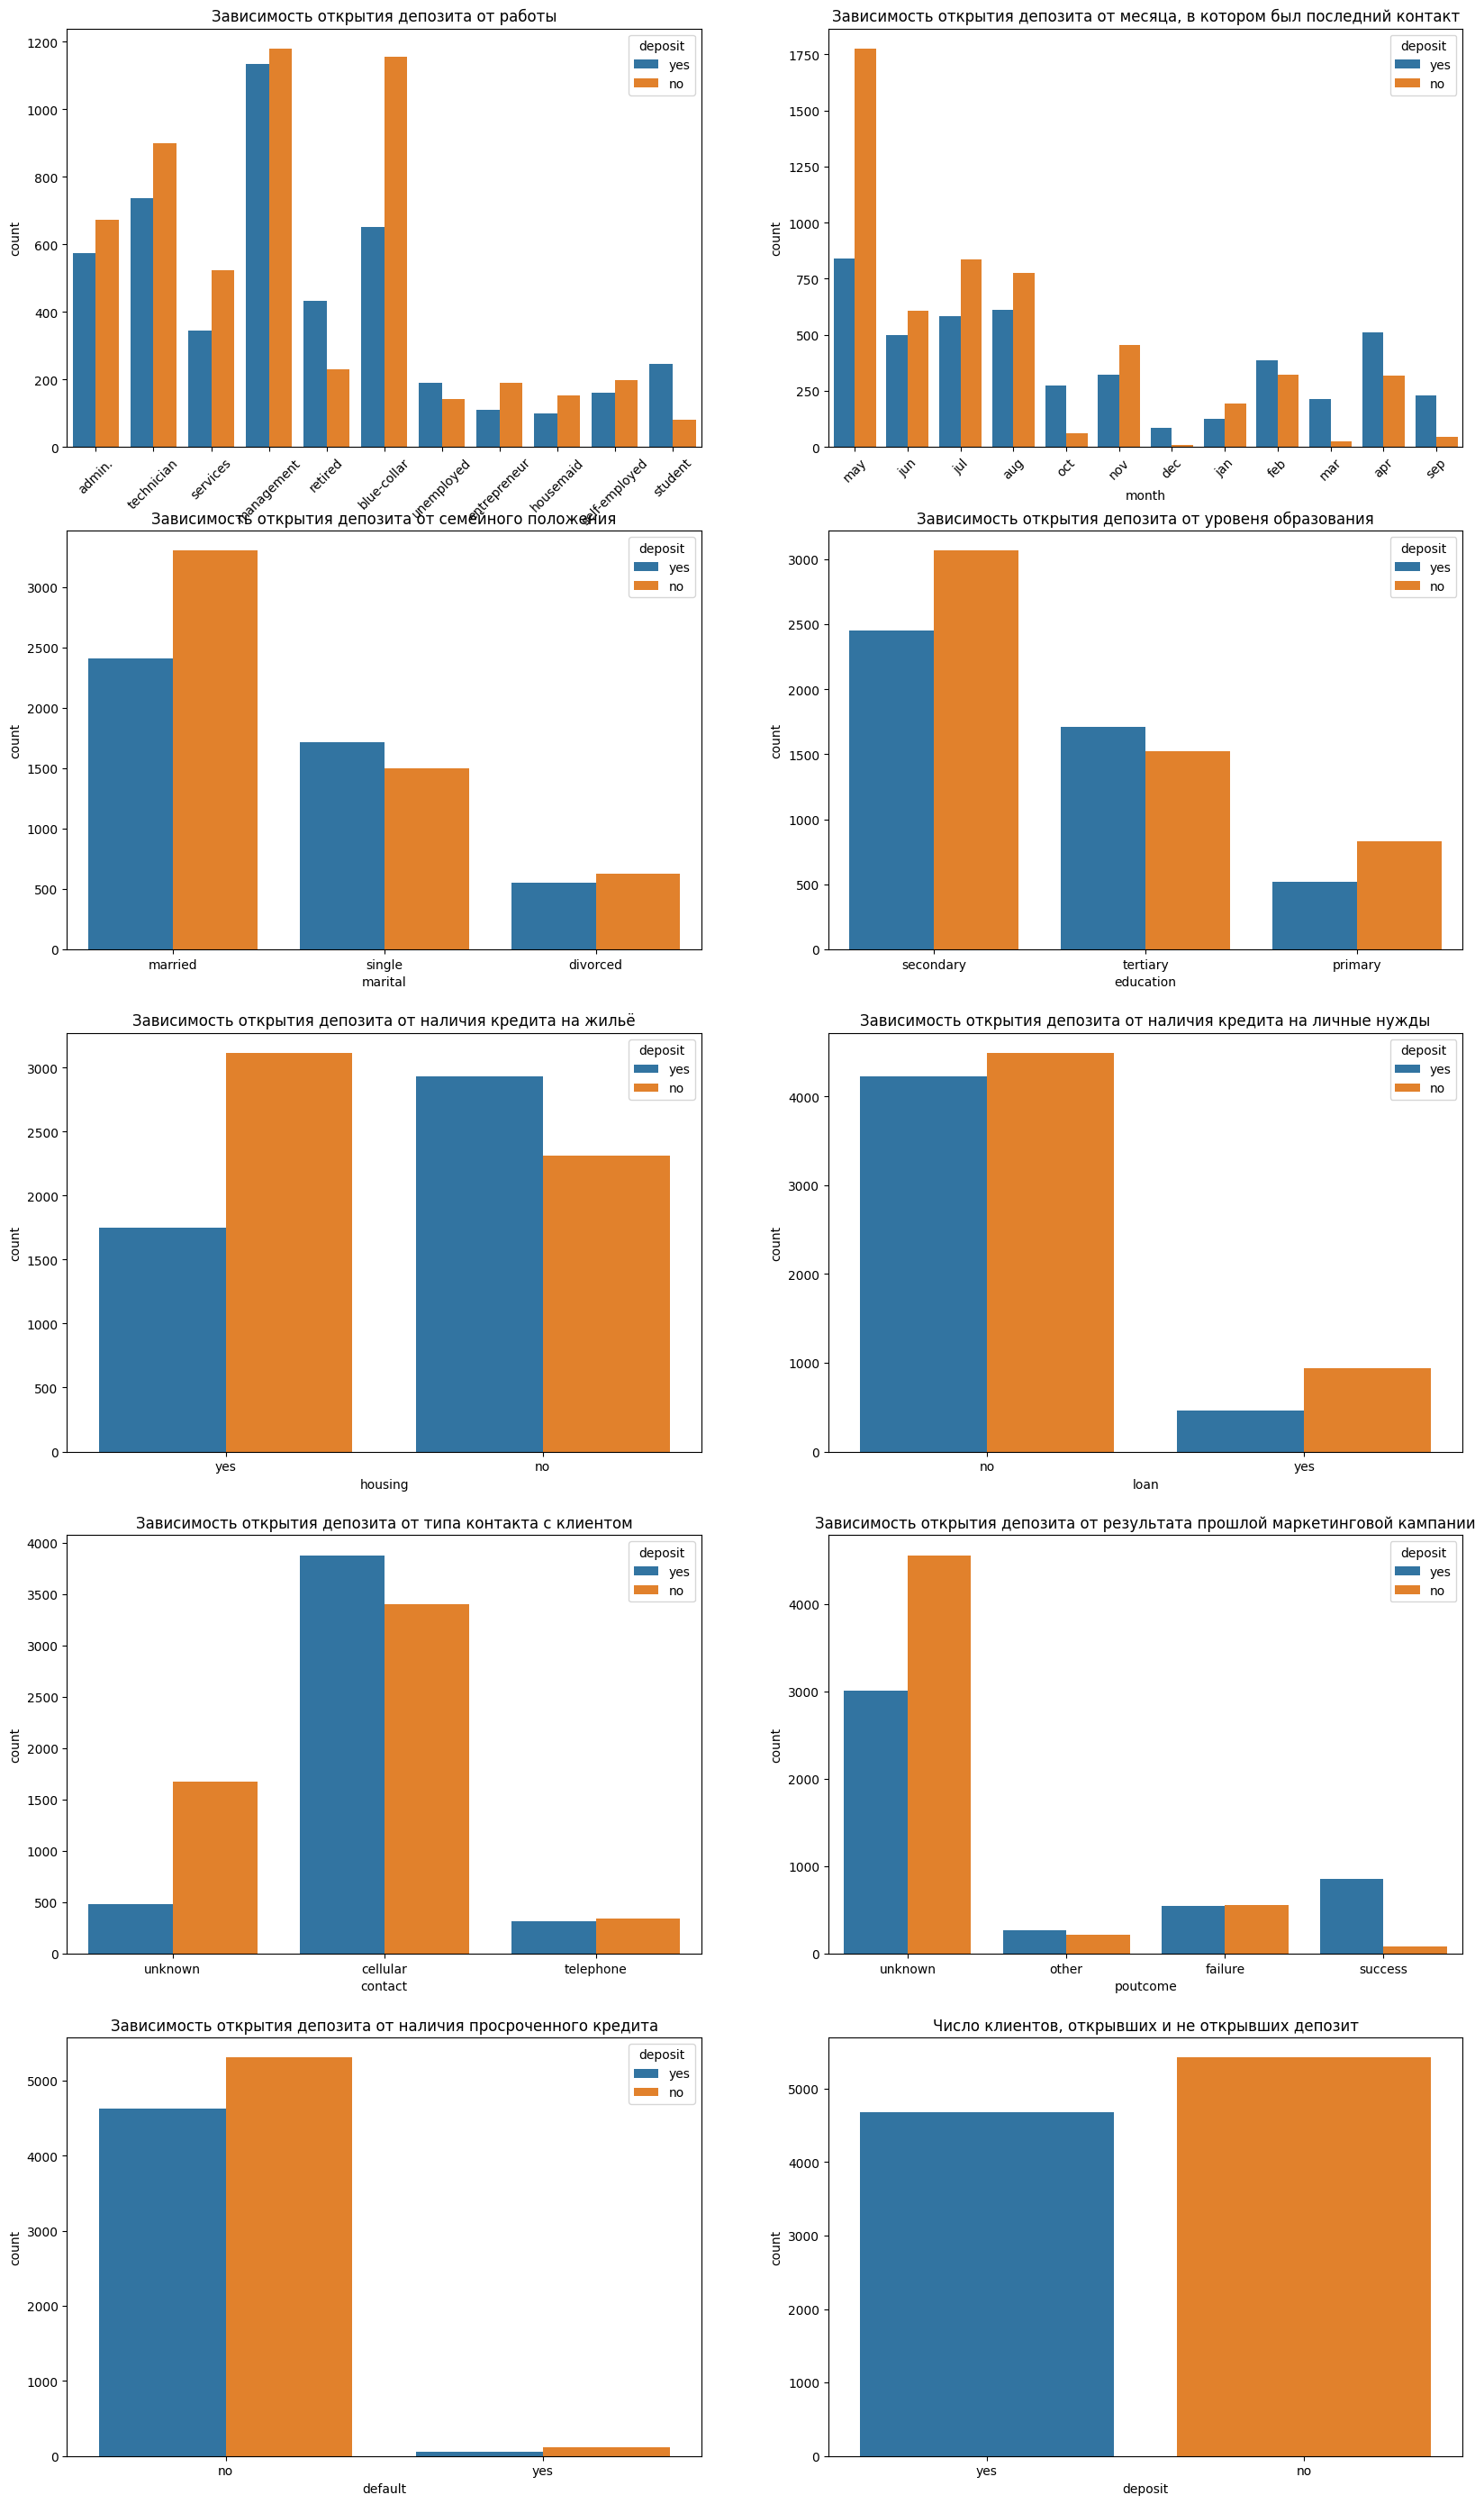

In [26]:
# Все описательные статистики
display(df.describe(include = 'object'))

# Строим графики зависимости согласия клиента открыть депозит от возраста, и от продолжительности контакта в секундах
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 35))

countplot_df = sns.countplot(data=df, x='job', hue = 'deposit', ax=axes[0][0]);
countplot_df.set_title('Зависимость открытия депозита от работы');
countplot_df.xaxis.set_tick_params(rotation=45)

countplot_df = sns.countplot(data=df, x='month', hue = 'deposit', ax=axes[0][1]);
countplot_df.set_title('Зависимость открытия депозита от месяца, в котором был последний контакт');
countplot_df.xaxis.set_tick_params(rotation=45)

countplot_df = sns.countplot(data=df, x='marital', hue = 'deposit', ax=axes[1][0]);
countplot_df.set_title('Зависимость открытия депозита от семейного положения');

countplot_df = sns.countplot(data=df, x='education', hue = 'deposit', ax=axes[1][1]);
countplot_df.set_title('Зависимость открытия депозита от уровеня образования');

countplot_df = sns.countplot(data=df, x='housing', hue = 'deposit', ax=axes[2][0]);
countplot_df.set_title('Зависимость открытия депозита от наличия кредита на жильё');

countplot_df = sns.countplot(data=df, x='loan', hue = 'deposit', ax=axes[2][1]);
countplot_df.set_title('Зависимость открытия депозита от наличия кредита на личные нужды');

countplot_df = sns.countplot(data=df, x='contact', hue = 'deposit', ax=axes[3][0]);
countplot_df.set_title('Зависимость открытия депозита от типа контакта с клиентом');

countplot_df = sns.countplot(data=df, x='poutcome', hue = 'deposit', ax=axes[3][1]);
countplot_df.set_title('Зависимость открытия депозита от результата прошлой маркетинговой кампании');

countplot_df = sns.countplot(data=df, x='default', hue = 'deposit', ax=axes[4][0]);
countplot_df.set_title('Зависимость открытия депозита от наличия просроченного кредита');

countplot_df = sns.countplot(data=df, x='deposit', ax=axes[4][1]);
countplot_df.set_title('Число клиентов, открывших и не открывших депозит');

Из графиков видно, что наиболее склонны к открытию депозита следующие категории клиентов:
* пенсионеры, студенты, безработные;
* клиенты, по которым был достигнут успех в предыдущей маркетинговой кампании;
* одинокие клиенты;
* клиенты, не имеющие ипотеки;
* клиенты с высшим образованием;
* клиенты, с которыми связывались по мобильному телефону;
* клиенты, с которыми контактировали в феврале, сентябре, марте, апреле, октябре или декабре.

При этом склонность открывать депозиты этих групп не всегда соотноситься с большим притоком клиентов, так хоть в мае большинство клиентов отказалось от депозита, но их общее количество было столь велико, что по итогу число принявших депозит в этом месяце самое большое. Среди клиентов представлено 11 профессий. Самые популярные management и blue-collar. При этом blue-collar предпочитают не брать депозит, а management соглашается на депозит чуть меньше чем в 50%. Но так как таких людей большинство, то получается, что среди клиентов взявших депозит это самые популярные группы, хоть сами по себе они не очень склонны брать депозит. Так же больше всего семейных клиентов, на втором месте одинокие клиенты. Так семейные с меньшей вероятностью берут депозит, чем одинокие, но по итогу из-за того, что их больше, большая часть клиентов взявших депозит относятся к семейной группе.

### Задание 6

Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [30]:
# Для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
df.groupby('poutcome')['deposit'].value_counts().unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


Видно, что количество согласий на открытие депозита в рамках текущей кампании превалирует среди тех клиентов, результат участия которых в предыдущей кампании помечен категорией "успех" ("success"). Для категории "other" количество согласий тоже выше количества отказов, но превалированием это назвать нельзя.

### Задание 7

Узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит.

In [31]:
# Процент отказов/согласия по месяцам:
(df.groupby('month')['deposit'].value_counts(normalize=True).unstack() \
    * 100).sort_values('no', ascending=False)  

deposit,no,yes
month,,
may,67.863966,32.136034
jan,60.815047,39.184953
jul,58.956276,41.043724
nov,58.461538,41.538462
aug,55.956679,44.043321
jun,54.891304,45.108696
feb,45.557123,54.442877
apr,38.192771,61.807229
oct,18.507463,81.492537


Наибольший процент отказов приходится на май.

### Задание 8

Создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения.

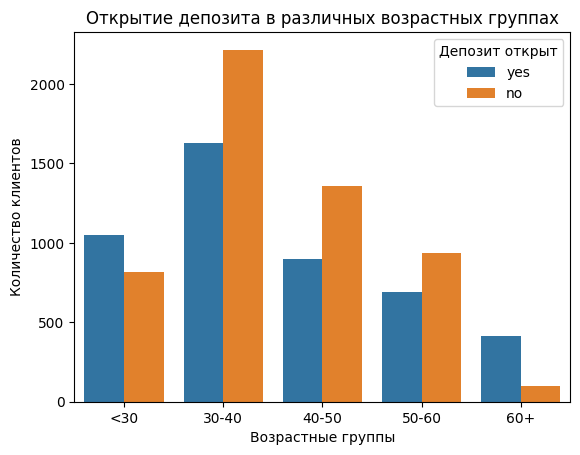

In [35]:
# Создаем возрастные группы
df['age_group'] = pd.cut(df['age'],
                                 [0,30,40,50,60,9999],
                                 labels = ['<30','30-40','40-50','50-60','60+'],
                                 right = True)

# Построим диаграмму для наглядности
countplot = sns.countplot(
    data = df,
    x = 'age_group',
    hue = 'deposit'
);

countplot.set_title('Открытие депозита в различных возрастных группах');
countplot.set_xlabel('Возрастные группы');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт');

Более склонны открывать депозиты клиенты моложе 30 и старше 60 лет.

### Задания 9 и 10

Постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса, в зависимости от образования, в зависимости от вида профессиональной занятости.

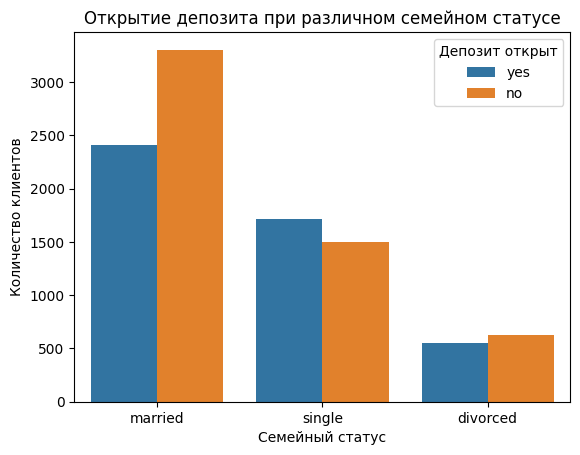

In [36]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
countplot = sns.countplot(
    data = df,
    x = 'marital',
    hue = 'deposit'
);

countplot.set_title('Открытие депозита при различном семейном статусе');
countplot.set_xlabel('Семейный статус');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт');

Наиболее многочисленная группа - семейные, наиболее малочисленная - разведенные. Одинокие более склонны к открытию депозита, чем семейные.

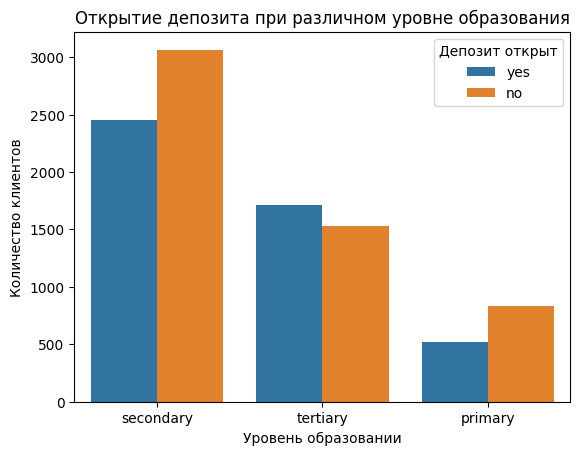

In [37]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
countplot = sns.countplot(
    data = df,
    x = 'education',
    hue = 'deposit'
);

countplot.set_title('Открытие депозита при различном уровне образования');
countplot.set_xlabel('Уровень образовании');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт');

У большинства клиентов среднее образование. Более склонны к открытию депозита клиенты с высшим образованием.

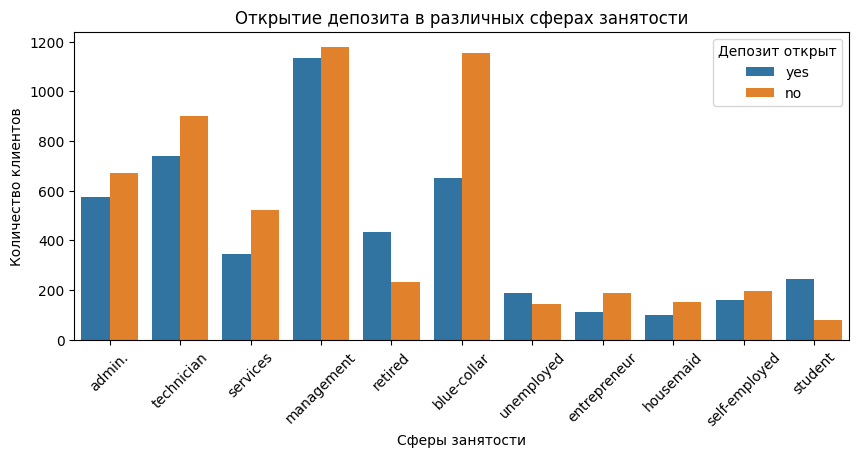

In [38]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(10,4))
countplot = sns.countplot(
    data = df,
    x = 'job',
    hue = 'deposit'
);

countplot.set_title('Открытие депозита в различных сферах занятости');
countplot.set_xlabel('Сферы занятости');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт');
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45);

Охотнее всего дают согласие вышедшие на пенсию, студенты и безработные. Малый процент открытия депозитов у "синих воротничков".

### Задание 11

Постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны (если рассматривать тех, кто открыл депозит).

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


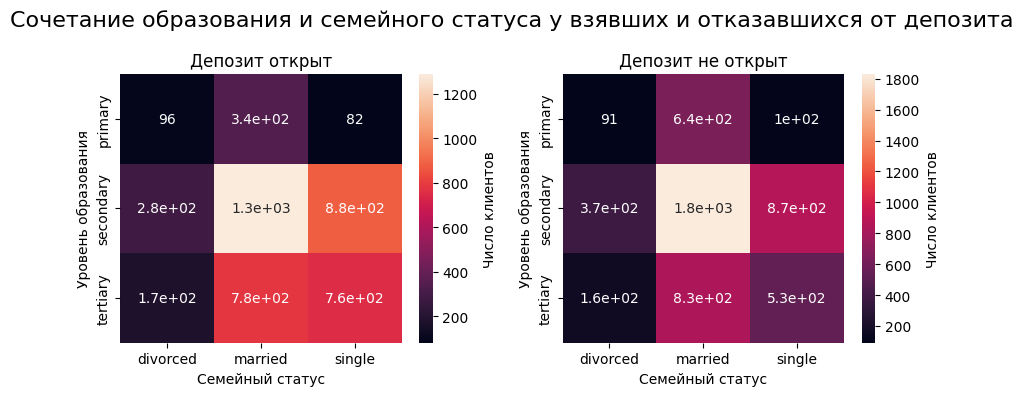

In [43]:
# Делим данные на открывших и не открывших депозит
success = df[df['deposit']=='yes']
fail = df[df['deposit']=='no']

# Создаем сводную таблицу открывших депозит
success_pivot = success.groupby(
    ['education', 'marital'])['marital'].count().unstack()

# Создаем сводную таблицу не открывших депозит
fail_pivot = fail.groupby(
    ['education', 'marital'])['marital'].count().unstack()

# Выводим сводные таблицы
display(success_pivot, fail_pivot)

# Визуализация
fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(success_pivot, cbar_kws = {'label':'Число клиентов'}, annot = True, ax=ax[0])
sns.heatmap(fail_pivot, cbar_kws = {'label':'Число клиентов'}, annot = True, ax=ax[1])
ax[0].set_title('Депозит открыт')
ax[1].set_title('Депозит не открыт')
ax[0].set(xlabel='Семейный статус', ylabel='Уровень образования')
ax[1].set(xlabel='Семейный статус', ylabel='Уровень образования')
plt.suptitle('Сочетание образования и семейного статуса у взявших и отказавшихся от депозита', fontsize=16)
plt.tight_layout()

В обеих категориях (открывшие и неоткрывшие депозит) преобладают семейные клиенты со средним образованием.

## Часть 3: преобразование данных

### Задание 1

Преобразуйте уровни образования.

In [50]:
# Кодирование
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

# Найдите сумму получившихся значений для признака
print(f'Сумму получившихся значений после кодирования для признака education: {df["education"].sum()}')

# Преобразуем порядковую переменную для возраста
df['age_group']  = le.fit_transform(df['age_group'])

Сумму получившихся значений после кодирования для признака education: 11995


### Задания 2 и 3

Преобразуйте бинарные переменные в представление из нулей и единиц.

In [51]:
# Преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = le.fit_transform(df['deposit'])
df['default'] = le.fit_transform(df['default'])
df['housing'] = le.fit_transform(df['housing'])
df['loan'] = le.fit_transform(df['loan'])

# Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit
print(round(df['deposit'].std(), 3))

# Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата
defaul_mean = df['default'].mean()
housing_mean = df['housing'].mean()
loan_mean = df['loan'].mean()
print(round(defaul_mean + housing_mean + loan_mean, 3))

0.499
0.635


### Задание 4

Создайте дамми-переменные.

In [65]:
# Cоздайте дамми-переменные
dummies = pd.get_dummies(df[[
    'job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, dummies], axis=1)

# Проверим размерность
print('Размерность датафрейма:', df.shape)

Размерность датафрейма: (10105, 51)


In [66]:
# Удаляем преобразованные признаки типа object
obj_cols = df.select_dtypes('object').columns
df.drop(columns=obj_cols, inplace=True)

### Задания 5 и 6

Постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности.

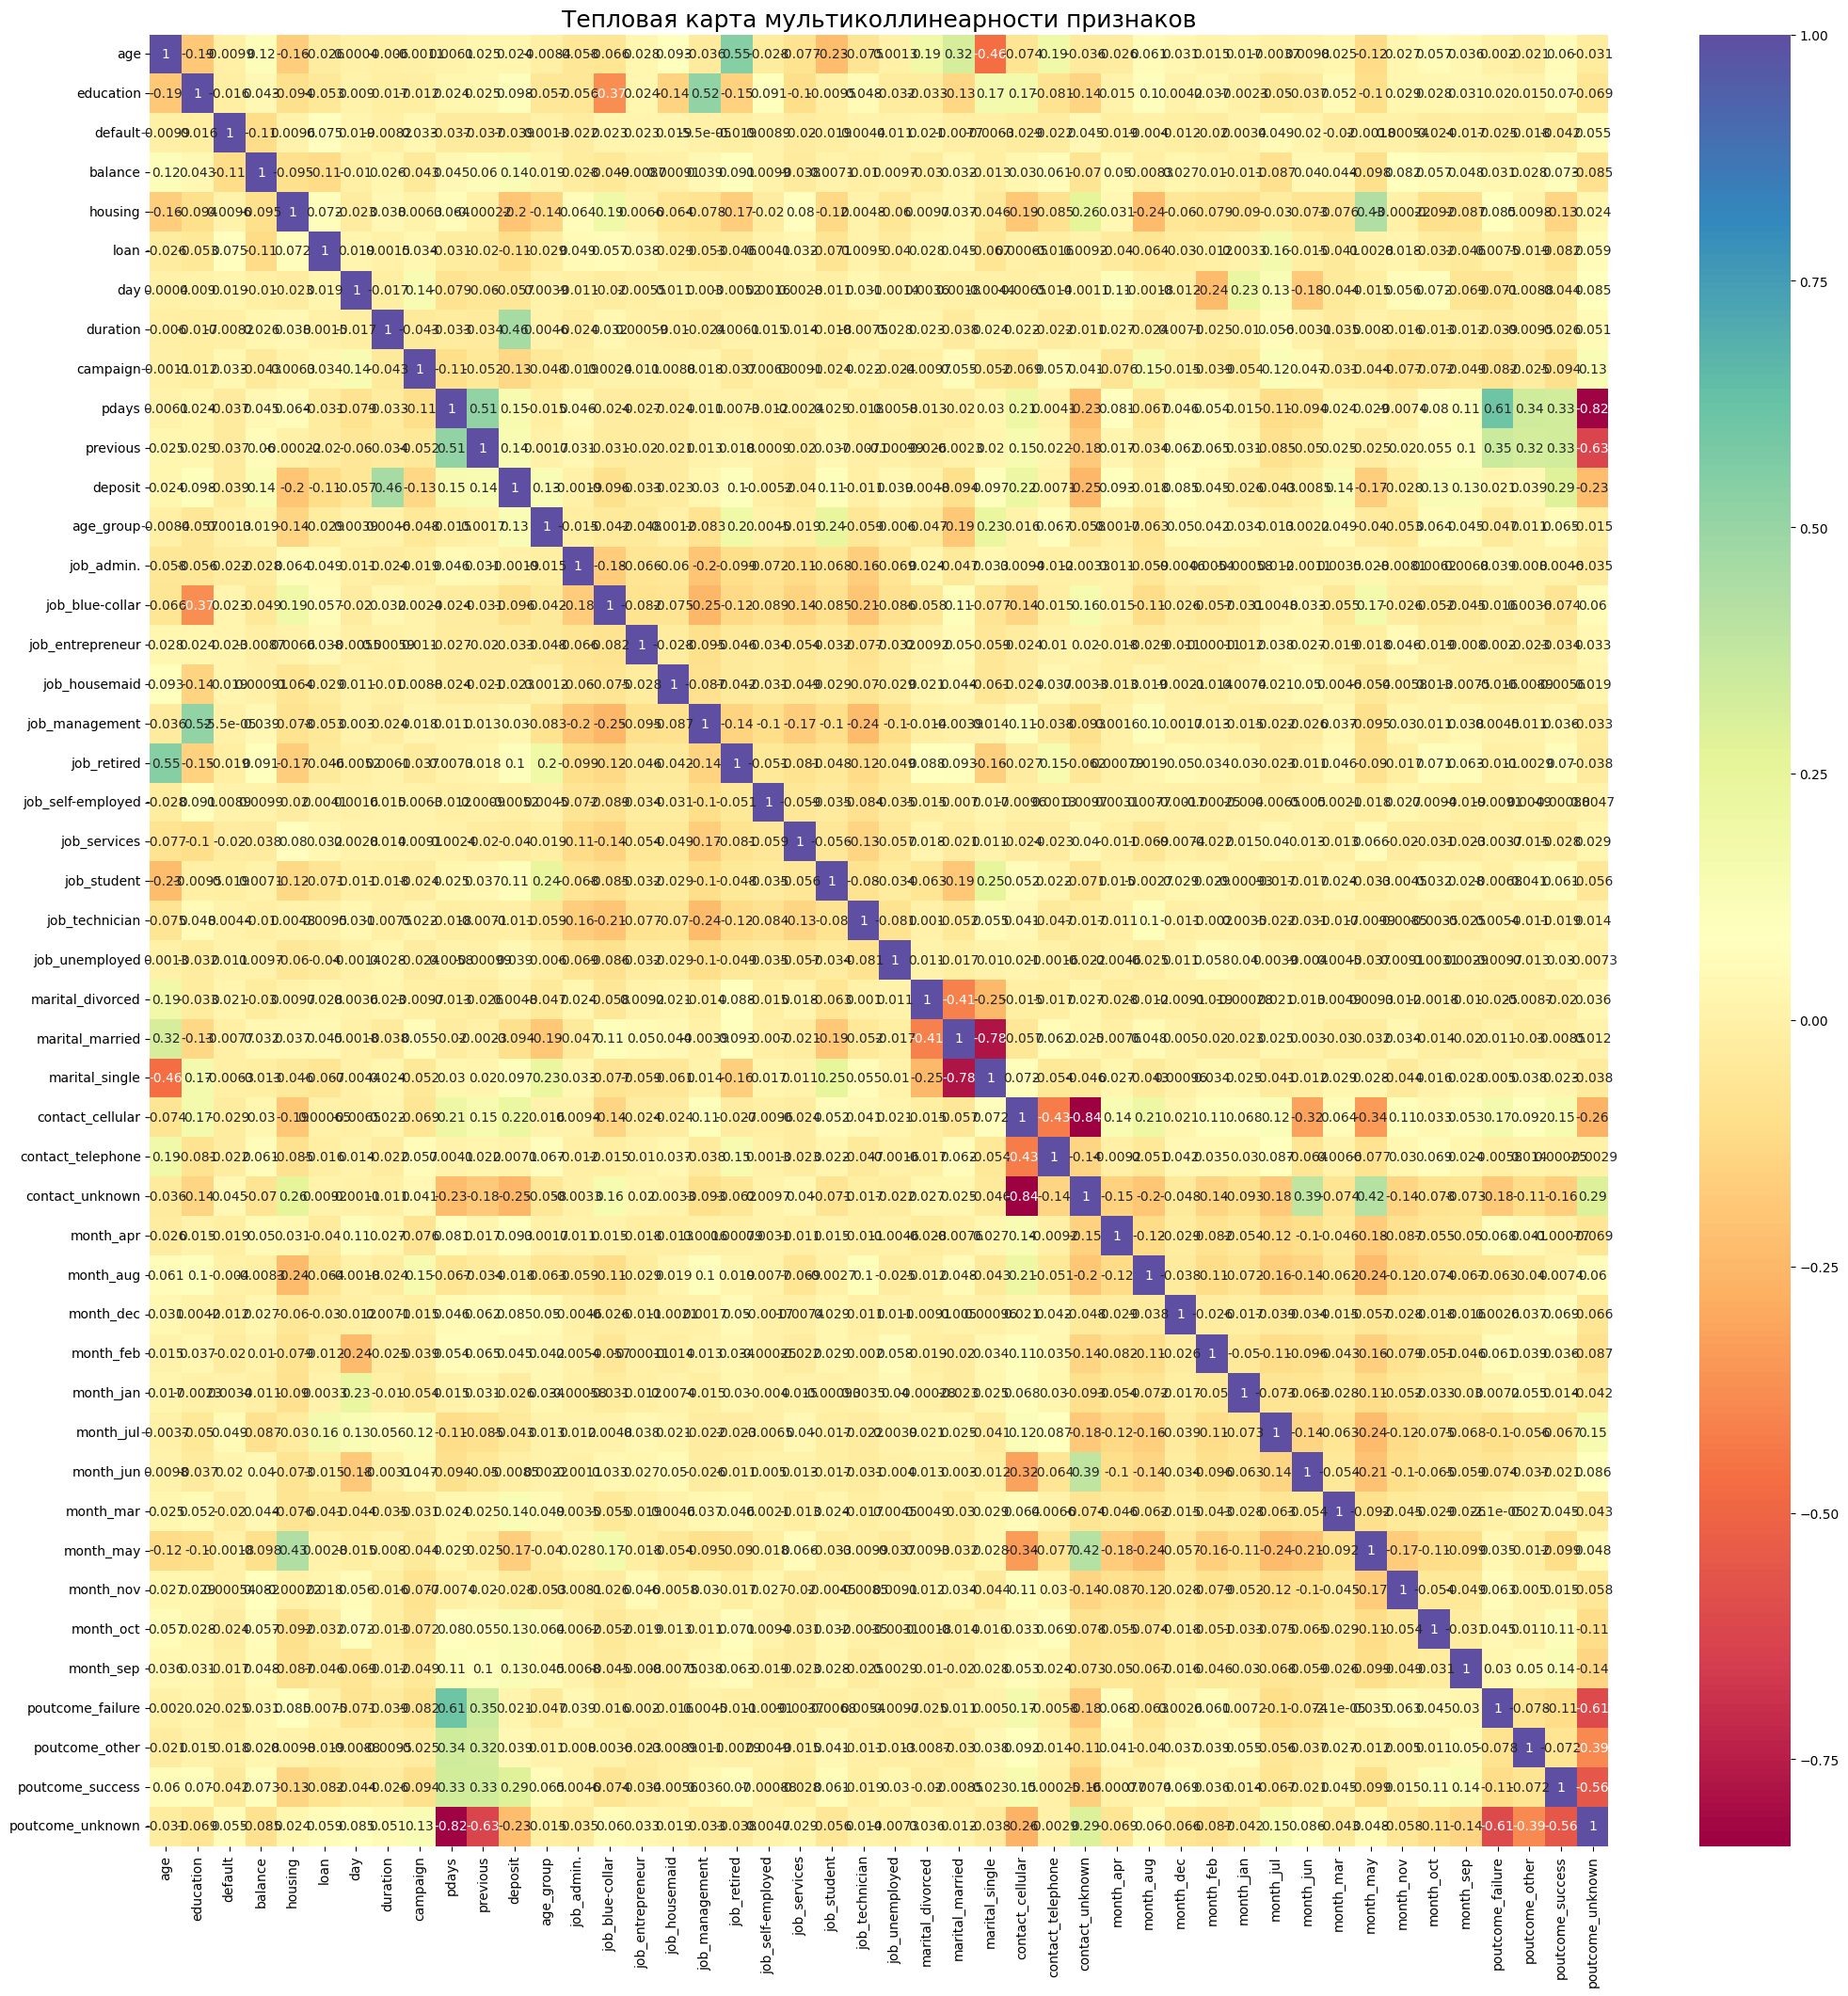

In [68]:
plt.rcParams['figure.figsize'] = (25,25)
heatmap = sns.heatmap(df.corr(numeric_only=True), cmap = 'Spectral', annot=True)
heatmap.set_title('Тепловая карта мультиколлинеарности признаков', fontsize=18);

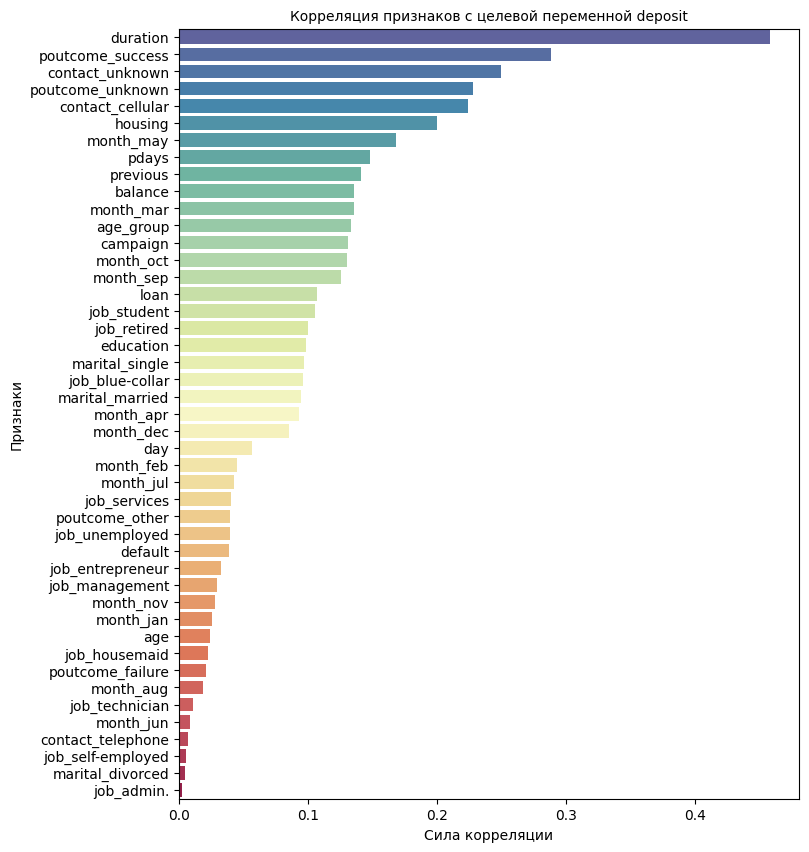

In [77]:
# Корреляции признаков с целевым deposit
dep_cor = df.corr()['deposit']
dep_cor = dep_cor.drop('deposit').abs().sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую эту корреляцию
fig = plt.figure(figsize=(8, 10))
barplot = sns.barplot(
    data = dep_cor.to_frame().reset_index(),
    x = 'deposit',
    y = 'index',
    orient = 'h',
    palette = 'Spectral_r'
);

barplot.set_title('Корреляция признаков с целевой переменной deposit', fontsize = 10);
barplot.set_xlabel('Сила корреляции');
barplot.set_ylabel('Признаки');

По тепловой карте видно, что отсутствуют сильно скоррелированные признаки (сила связи которых превышала бы 0.9). На диаграмме корреляции с целевой переменной видно, что наибольшим значением на принятие решения об открытии депозита обладают duration, poutcome_success, contact_unknown, poutcome_unknown, contact_cellular.

### Задания 7 и 8

In [78]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
# Стратифицированное разбиение
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

# Рассчитайте необходимые показатели
print('Размер тестовой выборки:', X_test.shape[0])
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print('Cреднее значение целевой переменной на тестовой выборке:', round(y_test.mean(),2))

Размер тестовой выборки: 3335
Размер обучающей выборки: 6770
Cреднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

С помощью SelectKBest отберите 15 наиболее подходящих признаков.

In [79]:
# С помощью SelectKBest отбираем 15 признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selected_feat = list(selector.get_feature_names_out())
display('Отобранные признаки:', selected_feat)

X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

'Отобранные признаки:'

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

Нормализуйте данные с помощью minmaxsxaler.

In [80]:
# Нормализация
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки
mean_X_test_1 = np.mean(X_test[:,0])
print("Среднее значение первого предиктора на тестовой выборке:", round(mean_X_test_1, 2))

Среднее значение первого предиктора на тестовой выборке: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Обучите логистическую регрессию и рассчитайте метрики качества.

In [81]:
# Создаем модель
log_reg = linear_model.LogisticRegression(solver ='sag', random_state=42, max_iter = 1000)

# Обучаем модель
log_reg.fit(X_train, y_train)

# Метрики все
y_train_pred_log = log_reg.predict(X_train)
y_test_pred_log = log_reg.predict(X_test)
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred_log, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred_log, digits=3)))

# Для анализа моделей в дальнейшем будем смотреть только метрику accuracy
# Метрика accuracy
print('Метрика accuracy на тренировочной выборке:',
        round(metrics.accuracy_score(y_train, y_train_pred_log), 2))
print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_pred_log), 2))

Обучающая выборка:
              precision    recall  f1-score   support

           0      0.810     0.878     0.843      3634
           1      0.843     0.761     0.800      3136

    accuracy                          0.824      6770
   macro avg      0.827     0.819     0.821      6770
weighted avg      0.825     0.824     0.823      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.793     0.870     0.830      1790
           1      0.830     0.737     0.781      1545

    accuracy                          0.808      3335
   macro avg      0.812     0.804     0.805      3335
weighted avg      0.810     0.808     0.807      3335

Метрика accuracy на тренировочной выборке: 0.82
Метрика accuracy на тестовой выборке: 0.81


### Задания 2,3,4

Обучите решающие деревья, настройте максимальную глубину.

In [82]:
# Создаем модель
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42)

# Обучаем модель
dt.fit(X_train, y_train)

# Делаем предсказание
y_train_pred_tree = dt.predict(X_train)
y_test_pred_tree = dt.predict(X_test)

# Выводим метрики
print('Метрика accuracy на тренировочной выборке:',
        round(metrics.accuracy_score(y_train, y_train_pred_tree), 2))
print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_pred_tree), 2))

Метрика accuracy на тренировочной выборке: 1.0
Метрика accuracy на тестовой выборке: 0.75


Метрика ухудшилась на тестовой выборке, и появилось переобучение. Нужно попробовать другие значения параметров.

Задание: Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

Максимальная точность на тесте: 0.815
Оптимальная глубина дерева: 6


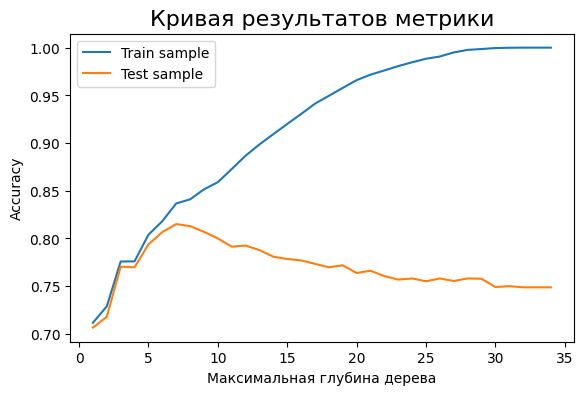

In [89]:
# Перебираем значения max_deph 
# Считаем accuracy на тренировочной и тестовой выборках
train_scores = []
test_scores = []
for max_depth in range(1,35):
    dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=max_depth)
    dt.fit(X_train, y_train)
    y_train_pred_dt = dt.predict(X_train)
    y_test_pred_dt = dt.predict(X_test)
    train_scores.append(metrics.accuracy_score(y_train, y_train_pred_dt))
    test_scores.append(metrics.accuracy_score(y_test, y_test_pred_dt))
    
# График
max_depth = list(range(1,35))
fig = plt.figure(figsize=(6.5, 4))
ax = sns.lineplot(x=max_depth, y=train_scores, label='Train sample')
sns.lineplot(x=max_depth, y=test_scores, label='Test sample')
ax.set(xlabel='Максимальная глубина дерева', ylabel='Accuracy')
ax.set_title('Кривая результатов метрики', fontsize=16);

# Оптимальный параметр
print(f'Максимальная точность на тесте: {np.amax(test_scores):.3f}')
print(f'Оптимальная глубина дерева: {np.argmax(test_scores)}')

In [88]:
# Создаем модель
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42, max_depth = 6)

# Обучаем модель
dt.fit(X_train, y_train)

# Делаем предсказание
y_train_pred_tree = dt.predict(X_train)
y_test_pred_tree = dt.predict(X_test)

# Выводим метрики
print('Метрика accuracy на тренировочной выборке:',
        round(metrics.accuracy_score(y_train, y_train_pred_tree), 2))
print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_pred_tree), 2))

Метрика accuracy на тренировочной выборке: 0.82
Метрика accuracy на тестовой выборке: 0.81


Лучшая глубина 6, метрика на тестовой выборке равна 0.81, а на тренировочной снизилась до 0.82. Это свидетельствует, что мы справились с переобучением.

### Задание 5

Подберите оптимальные параметры с помощью gridsearch.

In [100]:
# Создаем сетку перебираемых параметров
param_grid = {
    'min_samples_split': [2, 5, 7, 10], # мин. кол-во наблюдений для деления узла дерева
    'max_depth':[3, 5, 6, 7] # макс. глубина дерева
}

# Создаем модель GridSearch
grid_search = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        random_state = 42
    ), 
    param_grid = param_grid,
    scoring = ('f1'),
    return_train_score = True
)  

# Обучим модель
%time grid_search.fit(X_train, y_train)

# Сделаем предсказания
y_train_pred_gs = grid_search.predict(X_train)
y_test_pred_gs = grid_search.predict(X_test)

# Выведем метрики качества и значение гиперпараметров
print('Метрика accuracy на тренировочной выборке:', round(metrics.accuracy_score(y_train, y_train_pred_gs), 2))
print('Метрика accuracy на тестовой выборке:', round(metrics.accuracy_score(y_test, y_test_pred_gs), 2))
print('Метрика f1_score на тренировочной выборке:', round(metrics.f1_score(y_train, y_train_pred_gs), 2))
print('Метрика f1_score на тестовой выборке:', round(metrics.f1_score(y_test, y_test_pred_gs), 2))

print('Наилучшие значения гиперпараметров:', grid_search.best_params_)

CPU times: total: 4.94 s
Wall time: 6.45 s

Метрика accuracy на тренировочной выборке: 0.84
Метрика accuracy на тестовой выборке: 0.81
Метрика f1_score на тренировочной выборке: 0.83
Метрика f1_score на тестовой выборке: 0.8
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


В этот раз мы осуществляли подбор наилучших параметров с помощью GridSearchCV. Наилучшей оказалось глубина в 7 деревьев при минимальном числе наблюдений для деления узла 7. Метрики имеют хорошее значение.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Обучите на ваших данных случайный лес.

In [101]:
# Создаём объект класса RandomForestClassifier
rfс = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf = 5,
    random_state=42 #генератор случайных чисел
)


# Обучаем модель 
rfс.fit(X_train, y_train)
 
 
# Делаем предсказание класса
y_train_pred_rand = rfс.predict(X_train)
y_test_pred_rand = rfс.predict(X_test)


# Метрики все
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred_rand, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred_rand, digits=3)))

Обучающая выборка:
              precision    recall  f1-score   support

           0      0.875     0.856     0.866      3634
           1      0.838     0.858     0.848      3136

    accuracy                          0.857      6770
   macro avg      0.856     0.857     0.857      6770
weighted avg      0.858     0.857     0.857      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.851     0.821     0.836      1790
           1      0.801     0.833     0.817      1545

    accuracy                          0.827      3335
   macro avg      0.826     0.827     0.826      3335
weighted avg      0.828     0.827     0.827      3335



Модель случайного леса(ансамблевый метод) улучшить значение метрики на тестовой выборке до 0.83 по метрике accuracy по сравнению с деревом решений. Значит она имеет лучшую предсказательную способность.

### Задания 2 и 3

Используйте для классификации градиентный бустинг и сравните качество со случайным лесом.

In [103]:
# Создаем модель градиентного бустинга
gbс = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел
    min_samples_leaf = 5
)


# Обучаем модель
gbс.fit(X_train, y_train)


# Делаем предсказание класса
y_train_pred_gb = gbс.predict(X_train)
y_test_pred_gb = gbс.predict(X_test)


# Метрики все
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred_gb, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred_gb, digits=3)))

Обучающая выборка:
              precision    recall  f1-score   support

           0      0.902     0.885     0.893      3634
           1      0.870     0.888     0.879      3136

    accuracy                          0.887      6770
   macro avg      0.886     0.887     0.886      6770
weighted avg      0.887     0.887     0.887      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.850     0.822     0.836      1790
           1      0.801     0.832     0.816      1545

    accuracy                          0.826      3335
   macro avg      0.825     0.827     0.826      3335
weighted avg      0.827     0.826     0.827      3335



При сравнении случайного леса и градиентного бустинга видим, что метрики качества абсолютно идентичны. Таким образом, для решения данной задачи оба метода подходят.

### Задание 4

Объедините уже известные вам алгоритмы с помощью стекинга. 

In [108]:
estimators = [
    ('dtc', tree.DecisionTreeClassifier(criterion = 'entropy',
                                        random_state=42, 
                                        max_depth=7,
                                        min_samples_split=7,)),
    
    ('gbc',  GradientBoostingClassifier(
        learning_rate=0.05, 
        n_estimators=300,
        max_depth=5, 
        random_state=42, 
        min_samples_leaf = 5)),
    
]

# Создаем объект класса стекинг
stacking =  ensemble.StackingClassifier(
    estimators = estimators, #базовые модели в стекинге
    final_estimator = linear_model.LogisticRegression(solver ='sag',
                                        random_state=42, 
                                        max_iter = 1000)
)

# Обучаем модель
%time stacking.fit(X_train, y_train)

# Делаем предсказание класса
y_train_pred_stac = stacking.predict(X_train)
y_test_pred_stac = stacking.predict(X_test)


# Метрики все
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred_stac, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred_stac, digits=3)))

CPU times: total: 57.9 s
Wall time: 1min 18s
Обучающая выборка:
              precision    recall  f1-score   support

           0      0.895     0.883     0.889      3634
           1      0.866     0.880     0.873      3136

    accuracy                          0.881      6770
   macro avg      0.881     0.881     0.881      6770
weighted avg      0.882     0.881     0.881      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.846     0.827     0.837      1790
           1      0.805     0.826     0.815      1545

    accuracy                          0.827      3335
   macro avg      0.826     0.827     0.826      3335
weighted avg      0.827     0.827     0.827      3335



Стекинг, из всех рассмотренных моделей, не значительно  улучшил значения метрик, а выполнялся намного больше времени.

### Задание 5

Оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга.

duration            0.507106
poutcome_success    0.114958
contact_unknown     0.072582
balance             0.057952
pdays               0.055083
housing             0.047725
age_group           0.039902
month_mar           0.027819
month_oct           0.019880
month_may           0.015245
campaign            0.014777
month_sep           0.013530
previous            0.008439
contact_cellular    0.003620
poutcome_unknown    0.001382
dtype: float64

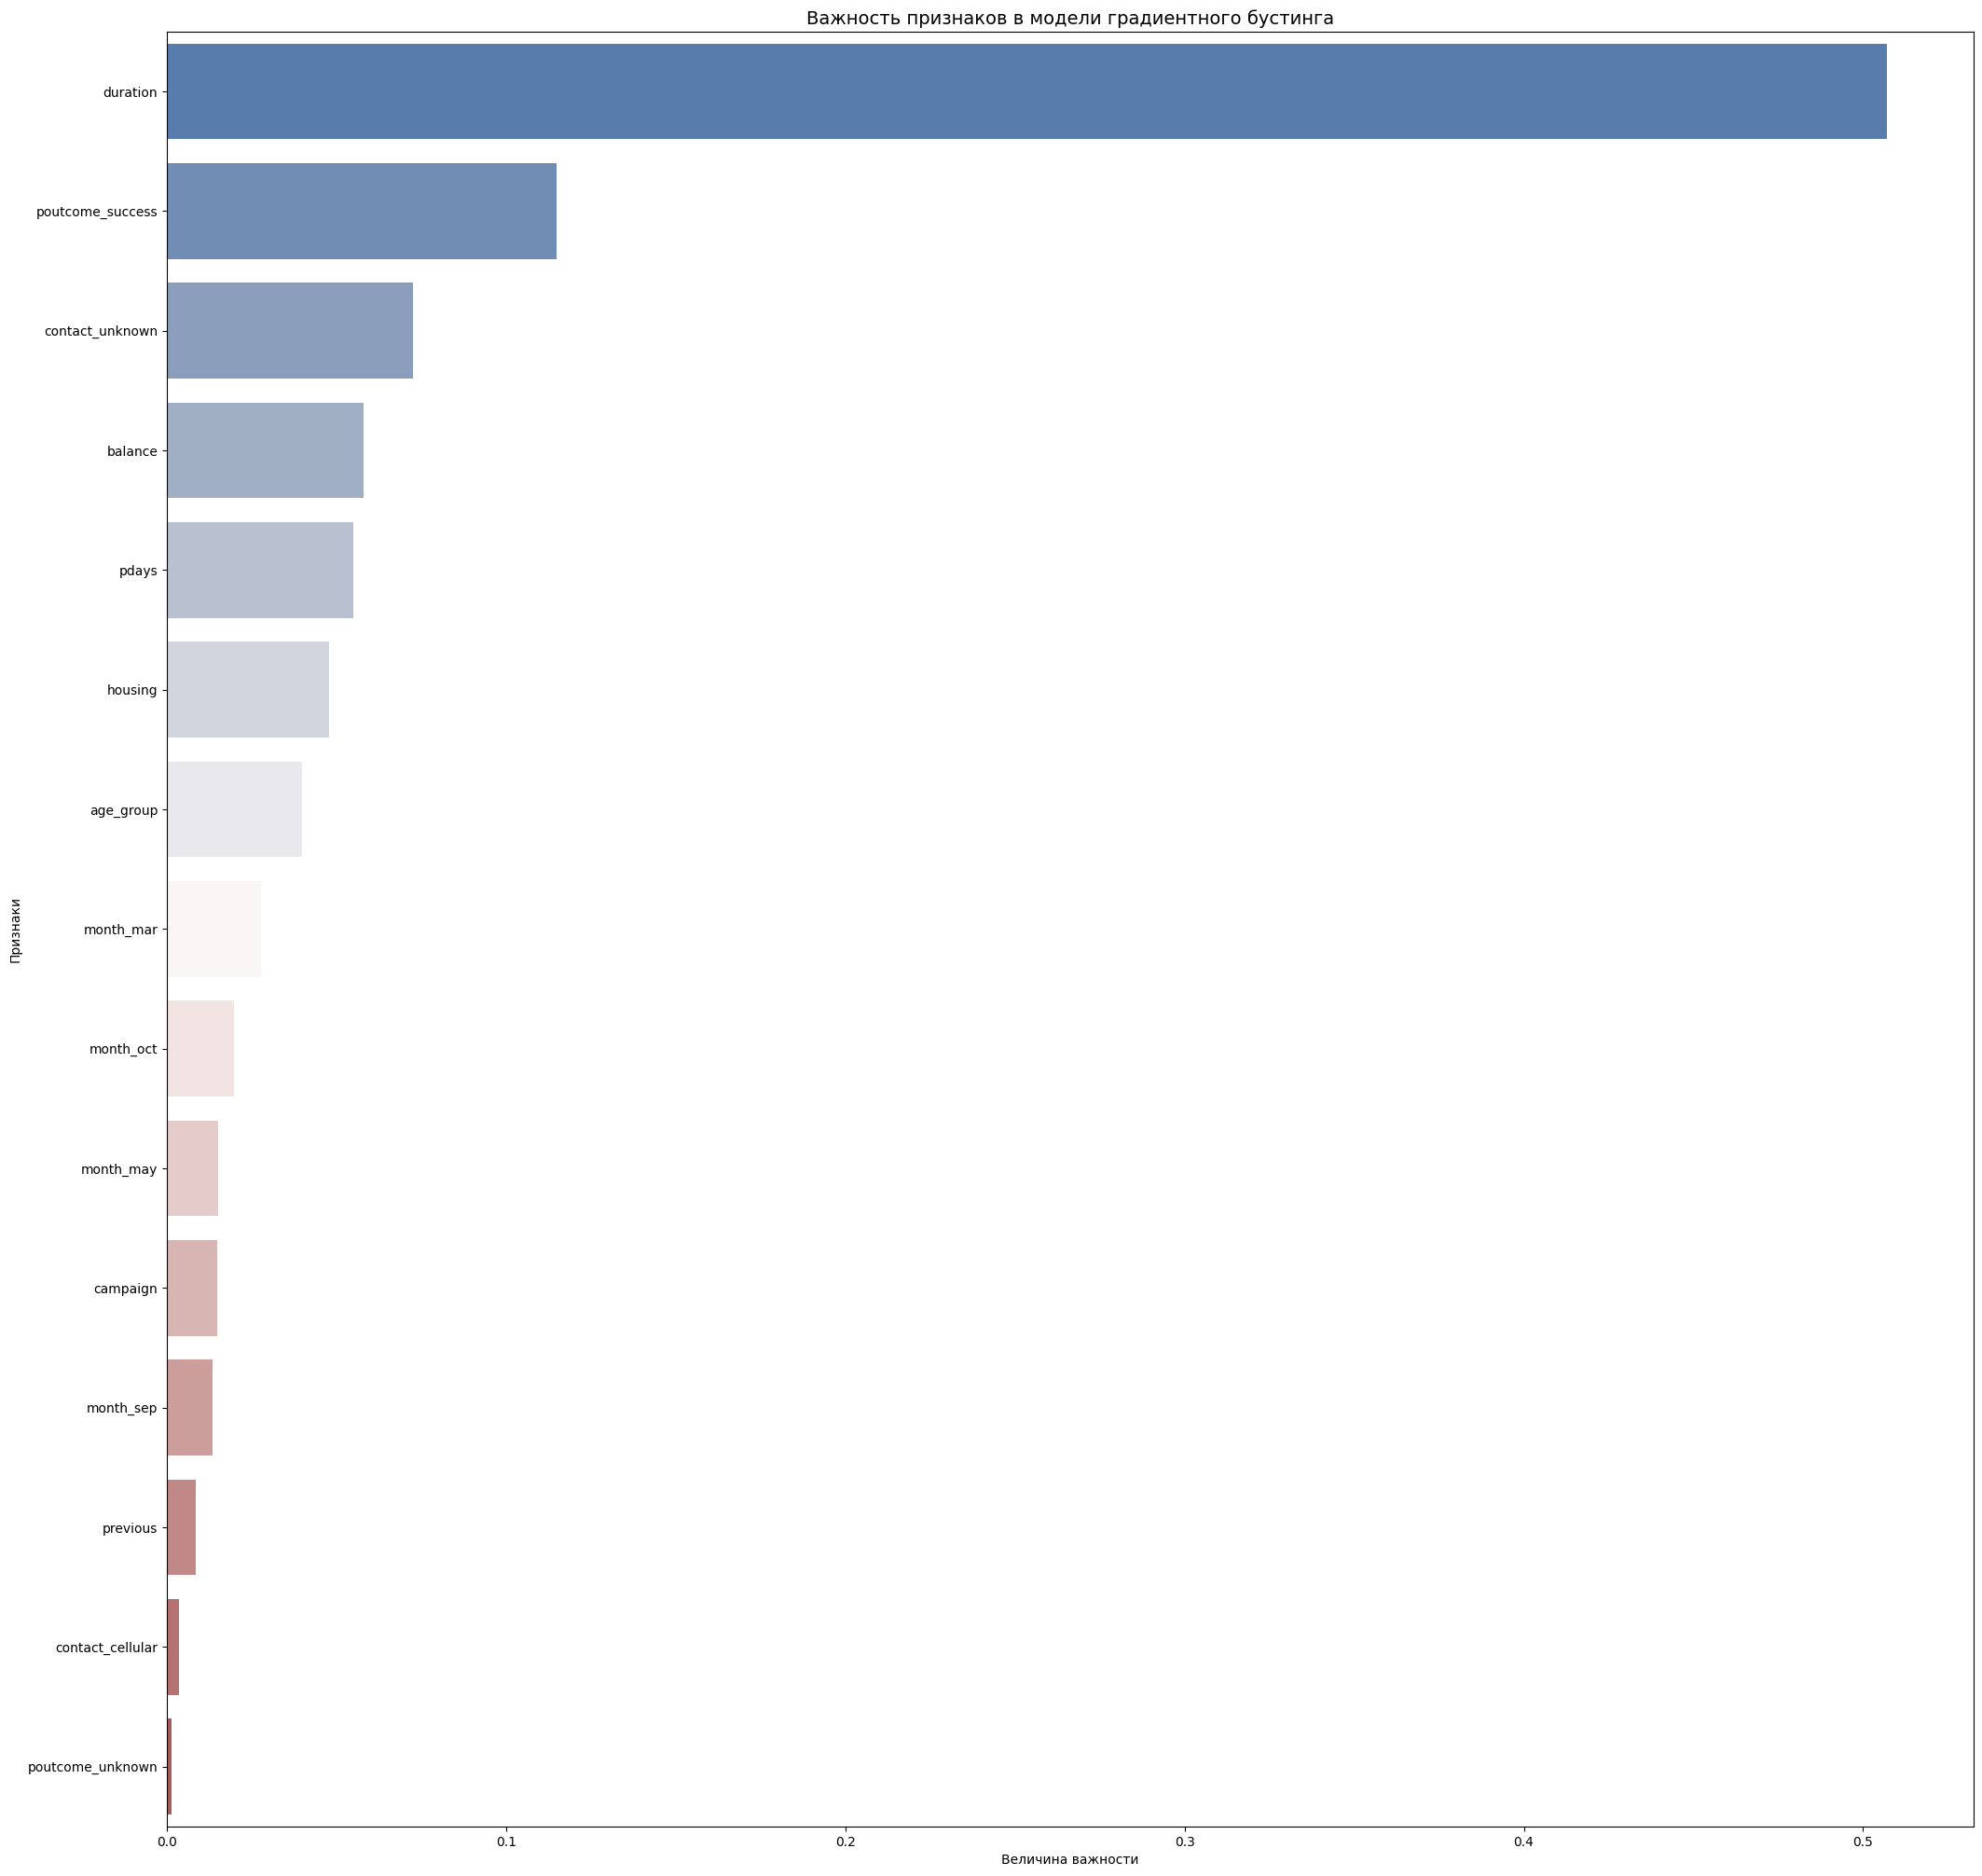

In [119]:
# Выделим важность призноков
gbс_feat = pd.Series(gbс.feature_importances_, selected_feat).sort_values(ascending=False)
display(gbс_feat)

# Построим диаграмму, иллюстрирующую важность признаков в модели
barplot = sns.barplot(
    data = gbс_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);

barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Длительность разговора оказывает очень большое значение на решение об открытии депозита, потому что сотрудник банка имеет возможность представить преимущества, поработать с возражениями и убедить клиента.

Так же положительный результат в прошлой кампании становится признаком того, что и в текущей клиент согласится с предложением банка, проявляя лояльность и доверие.

Почему признак контакт неизвестен, так важен для модели, сказать сложно. Возможно, в него входят самые эффективные способы связи с клиентом(мобильный телефон, личная встреча), которые не отразили, и поэтому он влияет на результат столь сильно.

In [ ]:
def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # обучаем модель
    model.fit(X_train, y_train)
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='RF_Classifier', direction='maximize')
study.optimize(obj_func, n_trials=10)
print(f'Лучшие параметры:\n{study.best_params}')

### Задания 6,7,8

Реализуйте оптимизацию гиперпараметров с помощью Optuna (реализуем для случайного леса).

In [121]:
# Создаем функцию максимализации
def optuna_rf(trial):
    #Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем модель
    model_optuna = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    # Обучаем модель
    model_optuna.fit(X_train, y_train)
    
    # Применим  cross validation
    score = cross_val_score(model_optuna, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

# Напрямую указываем, что нам необходимо максимизировать метрики
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# Выводим результаты гиперпараметров и метрики на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-11-08 22:05:08,879] A new study created in memory with name: RandomForestClassifier
[I 2023-11-08 22:06:12,295] Trial 0 finished with value: 0.8233245993214637 and parameters: {'n_estimators': 149, 'max_depth': 30, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8233245993214637.
[I 2023-11-08 22:06:22,420] Trial 1 finished with value: 0.8223170618706357 and parameters: {'n_estimators': 162, 'max_depth': 29, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8233245993214637.
[I 2023-11-08 22:06:35,374] Trial 2 finished with value: 0.8253444142769126 and parameters: {'n_estimators': 170, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8253444142769126.
[I 2023-11-08 22:06:42,689] Trial 3 finished with value: 0.8223771761523755 and parameters: {'n_estimators': 109, 'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8253444142769126.
[I 2023-11-08 22:06:49,188] Trial 4 finished with value: 0.8240197268526522 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 188, 'max_depth': 20, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.83


In [122]:
# Рассчитаем точность для тестовой выборки
model_opt = ensemble.RandomForestClassifier(**study.best_params,random_state=42 )
model_opt.fit( X_train, y_train)
y_test_pred_opt = model_opt.predict(X_test)

print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred_opt, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.857     0.815     0.835      1790
           1      0.797     0.842     0.819      1545

    accuracy                          0.828      3335
   macro avg      0.827     0.829     0.827      3335
weighted avg      0.829     0.828     0.828      3335



In [ ]:
# Зафиксируем библиотеки
#!pip freeze > requirements.txt

В целом, нам не удалось улучшить метрики на тестовой выборке.

# Общий вывод по проекту

Итак, в ходе проекта мы последовательно прошли через все этапы Data Science-задачи:

* Проведена предобработка признаков. 
* Проведен разведывательный анализ данных в контексте влияния на целевой признак.
* Проведено кодирование признаков и масштабирование значений. 
* На основе корреляции оценили влияния признаков на целевой признак. Отобрали наиболее важные признаки.
* Построены простые базовые модели - логистическая регрессия и решающее дерево.
* Построены ансамблевые модели.
* Реализованы примеры подбора гиперпараметров.
* На каждом этапе писали выводы.
* Использовали наглядные иллюстрации.
* На каждом этапе моделирования оценивались метрики качества классификации.

В итоге мы решили бизнес задачу по определению характеристик клиентов, более склонных к открытию депозита. Это семейные пары или одинокие клиенты с высшим образованием, предпочтительно в возрасте до 40 или старше 60, менеджеры, технические специалисты, а также студенты, безработные, пенсионеры. При этом важно их участие в предыдущих маркетинговых кампаниях банка без отрицательного негативного отношения. Предпочтительный способ связи с ними - по мобильному телефону или при личной встрече в банке.

Мы решили и техническую задачу, предложив несколько обученных моделей. Лучшая модель случайный лес с оптимизацией гиперпараметров Optuna.

Остается потенциал по возможному улучшению метрик при более тщательной и творческой обработке признаков, экспериментировании с различными моделями.